# Aligning mid-resolution brain volumes of 2 individuals with fMRI data

In [35]:
import contextlib
import warnings

import gdist
import joblib
import networkx as nx
import numpy as np
import torch

from fugw.utils import get_progress
from joblib import delayed, Parallel
from scipy.sparse import coo_matrix


@contextlib.contextmanager
def rich_progress_joblib(description=None, total=None, verbose=False):
    if description is None:
        description = "Processing..."

    progress = get_progress()
    if verbose:
        task_id = progress.add_task(description, total=total)

    class BatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            if verbose:
                progress.update(task_id, advance=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_callback = joblib.parallel.BatchCompletionCallBack

    try:
        joblib.parallel.BatchCompletionCallBack = BatchCompletionCallback
        progress.start()

        yield progress
    finally:
        progress.stop()
        joblib.parallel.BatchCompletionCallBack = old_callback


def compute_geodesic_distances(coordinates, triangles, index):
    if isinstance(coordinates, torch.Tensor) or isinstance(
        triangles, torch.Tensor
    ):
        coordinates = np.array(coordinates)
        triangles = np.array(triangles)

    geodesic_distances = torch.from_numpy(
        gdist.compute_gdist(
            coordinates.astype(np.float64),
            triangles.astype(np.int32),
            np.array([index]).astype(np.int32),
        )
    )

    return geodesic_distances


def adjacency_matrix_from_triangles(n, triangles):
    edges = np.hstack(
        (
            np.vstack((triangles[:, 0], triangles[:, 1])),
            np.vstack((triangles[:, 0], triangles[:, 2])),
            np.vstack((triangles[:, 1], triangles[:, 0])),
            np.vstack((triangles[:, 1], triangles[:, 2])),
            np.vstack((triangles[:, 2], triangles[:, 0])),
            np.vstack((triangles[:, 2], triangles[:, 1])),
        )
    )
    values = np.ones(edges.shape[1])

    # Divide data by 2 since all edges i -> j are counted twice
    # because they all belong to exactly two triangles on the mesh
    adjacency = coo_matrix((values, edges), (n, n)).tocsr() / 2

    # Making it symmetrical
    adjacency = (adjacency + adjacency.T) / 2

    return adjacency


def compute_geodesic_distances_from_graph(graph, coordinates, index):
    def weights(u, v, _):
        return np.linalg.norm(coordinates[u] - coordinates[v])

    print(len(list(graph)), coordinates.shape, index)
    d = nx.single_source_dijkstra_path_length(
        graph, int(index), weight=weights
    )
    geodesic_distances = np.array(list(d.values()))[list(d.keys())]

    return torch.from_numpy(geodesic_distances)

def compute_euclidean_distance(coordinates, index):
    return (coordinates - coordinates[index,:]).norm(dim=1)
    


def compute_lmds(
    coordinates,
    triangles,
    n_landmarks=100,
    k=3,
    n_jobs=2,
    tol=1e-3,
    verbose=False,
):
    """
    Compute embedding in k-dimension approximating
    the matrix D of geodesic distances on a given mesh
    Parameters
    ----------
    coordinates: array of size (n, 3)
        Coordinates of vertices
    triangles: array of size (t, 3)
        Triplets of indices indicating faces
    n_landmarks: int, optional, defaults to 100
        Number of vertices to sample on mesh to approximate embedding
    k: int, optional, defaults to 3
        Dimension of embedding
    n_jobs: int, optional, defaults to 2
        Number of CPUs to use to parallelise computation
    tol: float, optional, defaults to 1e-3
        Relative tolerance used to check intermediate results
    verbose: bool, optional, defaults to False
        Log solving process
    Returns
    -------
    X: torch.Tensor of size (n, k)
        Embedding such that cdist(X, X) approximates D
    """
    n_voxels = coordinates.shape[0]
    indices = torch.randperm(n_voxels)
    invert_indices = torch.empty_like(indices)
    invert_indices[indices] = torch.arange(n_voxels)
    basis_indices = indices[:n_landmarks]

    #adjacency = adjacency_matrix_from_triangles(
    #    coordinates.shape[0], triangles
    #)
    #graph = nx.Graph(adjacency)

    with rich_progress_joblib(
        "Geodesic_distances for landmarks",
        total=basis_indices.shape[0],
        verbose=verbose,
    ):
        basis_distance = torch.vstack(
            Parallel(n_jobs=n_jobs)(
                #delayed(compute_geodesic_distances)(
                #    coordinates,
                #    triangles,
                #    index,
                #)
                delayed(compute_euclidean_distance)(
                    coordinates,
                    index,
                )
                for index in basis_indices
            )
        )[:, indices]
    basis_distance = basis_distance.type(torch.float32)

    E = basis_distance[:, :n_landmarks]
    F = basis_distance[:, n_landmarks:]

    E_squared = E * E
    E_squared_sum = E_squared.sum()

    F_squared = F * F

    # Check E is symmetric
    E_Et_abs_max = torch.max(torch.abs(E - E.T))
    E_abs_max = torch.max(torch.abs(E))
    if not E_Et_abs_max <= tol * E_abs_max:
        warnings.warn(
            f"E might not be symmetric ({E_Et_abs_max} > {E_abs_max})"
        )

    # Double centring of A
    A = (
        -(
            E_squared
            - (
                torch.tile(torch.sum(E_squared, dim=0), (n_landmarks, 1))
                / n_landmarks
            )
            - (
                torch.tile(torch.sum(E_squared, dim=1), (n_landmarks, 1)).T
                / n_landmarks
            )
            + E_squared_sum / (n_landmarks**2)
        )
        / 2
    )

    # Check A is symmetric
    A_At_abs_max = torch.max(torch.abs(A - A.T))
    A_abs_max = torch.max(torch.abs(A))
    if not A_At_abs_max <= tol * A_abs_max:
        warnings.warn(
            f"A might not be symmetric ({A_At_abs_max} > {A_abs_max})"
        )

    # Check that np.ones(n_landmarks) is an eigen vector
    # associated with eigen value 0 to control double centering
    t = torch.ones(n_landmarks) @ A @ torch.ones(n_landmarks)
    if not t <= tol:
        warnings.warn(f"A might not be centered ({t} > {tol})")

    B = (
        -1
        / 2
        * (
            F_squared
            - torch.tile(
                torch.sum(E_squared, axis=1), (n_voxels - n_landmarks, 1)
            ).T
            / n_landmarks
        )
    )

    S, U = torch.linalg.eig(A)
    S = S.real
    U = U.real

    eig_indices = S.argsort().flip(0)
    S_min = torch.min(S)
    S = S[eig_indices] - S_min
    U = U[:, eig_indices]

    X = torch.vstack(
        [
            (U * torch.sqrt(torch.abs(S)))[:, :k],
            (U[:, :k].T @ B).T
            / torch.tile(
                torch.sqrt(torch.abs(S))[:k], (n_voxels - n_landmarks, 1)
            ),
        ]
    )

    # Reorder voxels to match original mesh order
    X = X[invert_indices]

    return X

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, image, plotting
from nilearn.image import get_data
from fugw.mappings import FUGW, FUGWSparse

In [37]:
n_subjects = 2

contrasts = [
    "sentence reading vs checkerboard",
    "sentence listening",
    "calculation vs sentences",
    "left vs right button press",
    "checkerboard",
]
n_training_contrasts = 4

brain_data = datasets.fetch_localizer_contrasts(
    contrasts,
    n_subjects=n_subjects,
    get_anats=True,
)

source_imgs_paths = brain_data["cmaps"][0 : len(contrasts)]
target_imgs_paths = brain_data["cmaps"][len(contrasts) : 2 * len(contrasts)]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/nilearn/datasets/func.py:763: UserWarning:

`legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.



In [38]:
#plotting.plot_stat_map(image.index_img(source_imgs_paths,0), title='Source, contrast : sentence reading vs checkerboard', threshold=3)
#plotting.plot_stat_map(image.index_img(target_imgs_paths,0), title='Target, contrast : sentence reading vs checkerboard', threshold=3)
#plt.show()

In [39]:
source_im = image.load_img(source_imgs_paths)
target_im = image.load_img(target_imgs_paths)
assert source_im.shape == target_im.shape

In [40]:
source_features = np.nan_to_num(source_im.get_fdata())
target_features = np.nan_to_num(target_im.get_fdata())

#Z = 0
#plt.imshow(source_features[:,:,Z,0], cmap='gray')
#plt.show()


SCALE_FACTOR = 1


source_features = source_features[::SCALE_FACTOR,::SCALE_FACTOR,::SCALE_FACTOR]
target_features = target_features[::SCALE_FACTOR,::SCALE_FACTOR,::SCALE_FACTOR]
data = source_features[:,:,:,0] !=0

## Compute distance matrix

In [41]:
mat = np.array(np.nonzero(data)).T
source_geometry = compute_lmds(torch.Tensor(mat), None)
target_geometry = source_geometry.clone()
source_geometry.shape

Output()

torch.Size([61099, 3])

In [42]:
import plotly.express as px

vertex_index = 0

fig = px.scatter_3d(x=mat[:,0], y=mat[:,1], z=mat[:,2], color=source_geometry[:,vertex_index])
fig.update_traces(marker_size = 5)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=True )
fig.show()

In [43]:
source_features = source_features[data].T
target_features = target_features[data].T

In [44]:
# Normalization
source_features_normalized = source_features / np.linalg.norm(
source_features, axis=1
).reshape(-1, 1)
target_features_normalized = target_features / np.linalg.norm(
    target_features, axis=1
).reshape(-1, 1)
source_geometry_normalized = source_geometry / torch.max(source_geometry)
target_geometry_normalized = target_geometry / torch.max(target_geometry)

In [47]:
# Mapping training
fine_mapping = FUGWSparse(alpha=0.5, rho=1, eps=1e-4)
_ = fine_mapping.fit(
    source_features_normalized[:n_training_contrasts],
    target_features_normalized[:n_training_contrasts],
    source_geometry_embedding=source_geometry_normalized,
    target_geometry_embedding=target_geometry_normalized,
    solver="sinkhorn",
    solver_params={
        "nits_bcd": 3,
        "tol_uot": 1e-10,
    },
    verbose=True,
)

/Users/plbar/Research/fugw/src/fugw/mappings/sparse.py:146: UserWarning:




: 

: 

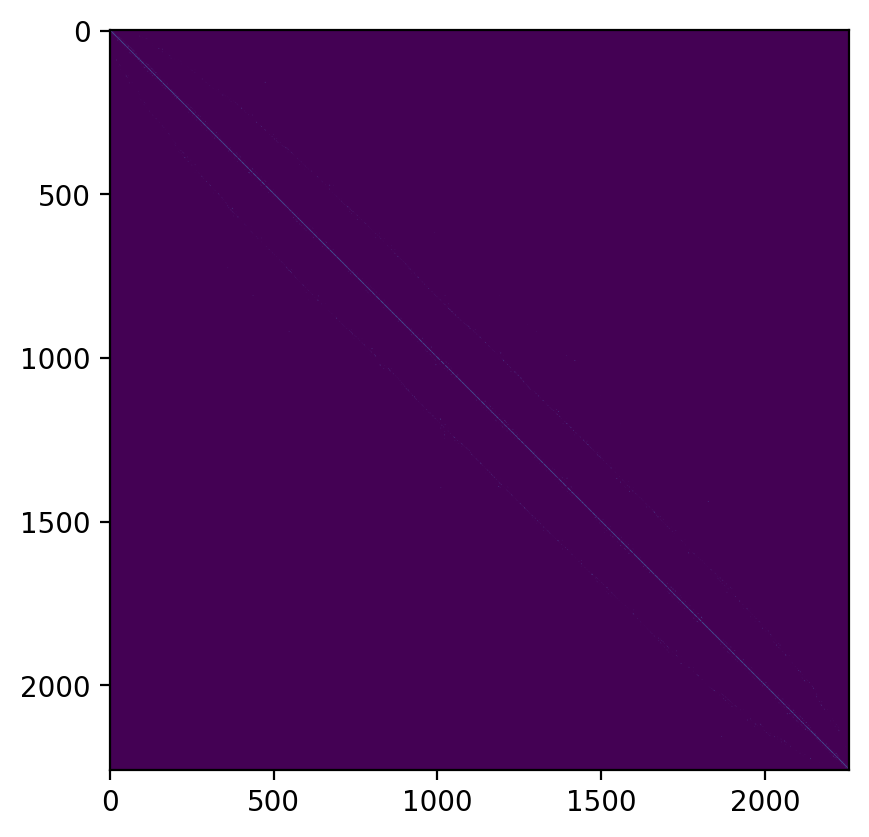

In [181]:
# Show mapping
pi = mapping.pi
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200
plt.imshow(pi, cmap='viridis')
plt.show()
plt.rcParams['figure.dpi'] = 100

In [182]:
# Reverse probability map
import plotly
vertex_index = 0

probability_map = pi[vertex_index, :] / np.sqrt(np.linalg.norm(pi[vertex_index, :]))

fig = px.scatter_3d(x=mat[:,0], y=mat[:,1], z=mat[:,2], color=np.asarray(probability_map), 
                    color_continuous_scale=plotly.colors.sequential.Reds)
fig.update_traces(marker_size = 5)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.show()

In [183]:
# Predict target features
contrast_index = -1
predicted_target_features = mapping.transform(
    source_features[contrast_index, :]
)
predicted_target_features.shape

(2258,)

In [184]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3,
                    specs=[[{"type": "scene"}, {"type": "scene"}, {"type": "scene"}]],
                    subplot_titles=("Source contrast", "Predicted target", "Actual target"))

fig.add_trace(
    go.Scatter3d(x = mat[:,0], y = mat[:,1], z = mat[:,2], mode = 'markers', 
                marker = dict(size = 4, color = np.asarray(source_features[-1,:])),
                name="Source contrast"), 
    row=1, col=1
    )
fig.add_trace(
    go.Scatter3d(x = mat[:,0], y = mat[:,1], z = mat[:,2], mode = 'markers',
                marker = dict(size = 5, color = np.asarray(predicted_target_features)),
                name="Predicted target"), 
    row=1, col=2
    )
fig.add_trace(
    go.Scatter3d(x = mat[:,0], y = mat[:,1], z = mat[:,2], mode = 'markers', 
                marker = dict(size = 5, color = np.asarray(target_features[-1,:])),
                name="Actual target"), 
    row=1, col=3
    )
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=True )
fig.show()


In [185]:
corr_pre_mapping = np.corrcoef(source_features[contrast_index, :], target_features[contrast_index, :])[0,1]
corr_post_mapping = np.corrcoef(predicted_target_features, target_features[contrast_index, :])[0,1]
print(f"Pearson Correlation pre-mapping: {corr_pre_mapping:.2f}")
print(f"Pearson Correlation post-mapping: {corr_post_mapping:.2f}")
print(f"Relative improvement: {(corr_post_mapping - corr_pre_mapping) / corr_pre_mapping *100 :.2f} %")

Pearson Correlation pre-mapping: 0.38
Pearson Correlation post-mapping: 0.47
Relative improvement: 23.58 %
